In [1]:
import numpy as np 
import scipy.io as sio
import os, os.path
import sys
import tensorflow as tf
import re
from dataset.dataset_utils import int64_feature, float_feature, bytes_feature ,ImageCoder, norm
import glob
import SimpleITK as sitk
from random import shuffle
from dataset.utils import writeImage, writeMedicalImage, fast_hist
import scipy.ndimage

from PIL import Image

train_data = "/home/jacob/Projects/image_segmentation/data"

val_data = "/home/jacob/Projects/image_segmentation/data/"

path_save =  '/home/jacob/Projects/image_segmentation/data/'

is_training = True


In [ ]:
def _convert_to_example(image_data, label):
	#print 'shape: {}, height:{}, width:{}'.format(shape,shape[0],shape[1])
	example = tf.train.Example(features=tf.train.Features(feature={
			'image/encoded': bytes_feature(image_data),
			'label/encoded': bytes_feature(label)
			}))
	return example
	
    
def _processing_image(seq, label, depth):
	seqs = []
	labs = []
	for d in [depth-2, depth-1, depth]:
		label_data = label[d]
		labs.append(np.array(label_data))
		mod = []
		for im in seq:
			image_data = im[d]
			#image_data = scipy.ndimage.interpolation.zoom(image_data, 2, order=1, mode='nearest')
			# upsample 
			mod.append(image_data)
		seqs.append(np.array(mod))
	seqs = np.array(seqs)
	labs = np.array(labs)
	return seqs.tobytes(), labs.tobytes()

def norm_image_by_patient(imname):
	im = sitk.GetArrayFromImage(sitk.ReadImage(imname)).astype(np.float32)
	return (im - im.mean()) / im.std()
	roi_index = im > 0
	mean = im[roi_index].mean()
	std = im[roi_index].std()
	im[roi_index] -= mean
	im[roi_index] /= std
	return im

def count_class_freq(label_batch):
    hist = np.zeros(5)
    imagesPresent = [0,0,0,0,0]
    for i in range(len(label_batch)):
        new_hist = np.bincount(label_batch[i], minlength=5)
        hist += new_hist
        for ii in range(5):
            if (new_hist[ii] != 0):
                imagesPresent[ii] += 1
    print(hist)
    freqs = [hist[v]/float((imagesPresent[v]+1e-5)*240*240) for v in range(5)]
    median = np.median(freqs)
    o = []
    for i in range(5):
        if (freqs[i] <= 1e-5):
            o.append(0.0)
        else:
            o.append(float(median)/(freqs[i]))
    print(o)
    return o

def checkLabel(label, d):
	if np.count_nonzero(label[d]) > 0:
		return True, 1
	else:
		return False, 0
    
def count_freq(labels):
	freq = np.array([0.0,0.0,0.0,0.0,0.0])
	for la in labels:
		freq += np.bincount(la, minlength=5).astype(np.float32)
	print(freq)
	print(freq/freq.sum())
	count_class_freq(labels)
    

## TfRecord_train 

In [ ]:
with tf.python_io.TFRecordWriter(path_save +"train_cmc_original2.tfrecord") as tfrecord_writer:
    
    folderHGG = glob.glob(train_data + '/HGG/*')
    folderLGG = glob.glob(train_data + '/LGG/*')
    folder_train = folderHGG[:-25] + folderLGG[:-5]
    folder_val = folderHGG[-25:] + folderLGG[-5:]
    tf_filename = path_save +'train_cmc_original2.tfrecord'

    all_example = []
    print("Saving training record....")
    all_label_data = []
    for index, i in enumerate(folder_train):
        print("dir_name =",os.path.split(i)[-1],"\n","idx =",index)
        imname = i.split("/")[-1]
        flair = glob.glob(i + '/*Flair*.mha')
        t2 = glob.glob(i + '/*T2*.mha')
        t1 = glob.glob(i + '/*T1*.mha')
        t1c = glob.glob(i + '/*T1c*.mha')
        t1 = [_t1 for _t1 in t1 if not _t1 in t1c]
        label = glob.glob(i + '/*OT*.mha')[0]
        label = sitk.GetArrayFromImage(sitk.ReadImage(label)).astype(np.float32)
        seq = [norm_image_by_patient(flair[0]),
               norm_image_by_patient(t2[0]),
               norm_image_by_patient(t1[0]),
               norm_image_by_patient(t1c[0])]
        ind = 0
        for depth in range(2,155):
            is_valid, sample_num = checkLabel(label, depth)
            if( not is_valid):
                continue
            for i in range(sample_num):
                image_data, label_data = _processing_image(seq, label, depth)
                #all_label_data.append(label[depth].flatten().astype(np.int64))
                example = _convert_to_example(image_data, label_data)
                all_example.append(example)
    print("slices:", len(all_example))
    shuffle(all_example)
    for ex in all_example:
        tfrecord_writer.write(ex.SerializeToString()) 
# [0.011868184281122324, 1.0859737711507338, 0.80660914716121235, 0.0, 1.0]
print('Transform to tfrecord finished')

## TfRecord_Test

In [ ]:
with tf.python_io.TFRecordWriter(path_save +"test_cmc_original2.tfrecord") as tfrecord_writer:
    
    folderHGG = glob.glob(train_data + '/HGG/*')
    folderLGG = glob.glob(train_data + '/LGG/*')
    folder_train = folderHGG[:-25] + folderLGG[:-5]
    folder_val = folderHGG[-25:] + folderLGG[-5:]
    tf_filename = path_save +'test_cmc_original2.tfrecord'

    all_example = []
    print("Saving training record....")
    all_label_data = []
    for index, i in enumerate(folder_val):
        print("dir_name =",os.path.split(i)[-1],"\n","idx =",index)
        imname = i.split("/")[-1]
        flair = glob.glob(i + '/*Flair*.mha')
        t2 = glob.glob(i + '/*T2*.mha')
        t1 = glob.glob(i + '/*T1*.mha')
        t1c = glob.glob(i + '/*T1c*.mha')
        t1 = [_t1 for _t1 in t1 if not _t1 in t1c]
        label = glob.glob(i + '/*OT*.mha')[0]
        label = sitk.GetArrayFromImage(sitk.ReadImage(label)).astype(np.float32)
        seq = [norm_image_by_patient(flair[0]),
               norm_image_by_patient(t2[0]),
               norm_image_by_patient(t1[0]),
               norm_image_by_patient(t1c[0])]
        ind = 0
        for depth in range(2,155):
            is_valid, sample_num = checkLabel(label, depth)
            if( not is_valid):
                continue
            for i in range(sample_num):
                image_data, label_data = _processing_image(seq, label, depth)
                #all_label_data.append(label[depth].flatten().astype(np.int64))
                example = _convert_to_example(image_data, label_data)
                all_example.append(example)
    print("slices:", len(all_example))
    shuffle(all_example)
    for ex in all_example:
        tfrecord_writer.write(ex.SerializeToString()) 
# [0.011868184281122324, 1.0859737711507338, 0.80660914716121235, 0.0, 1.0]
print('Transform to tfrecord finished')

## Test_BYTES_2_float(32)

In [ ]:
from matplotlib import pyplot
temp = tf.reshape(tf.decode_raw(image_data,tf.float32),[-1,4,240,240])
with tf.Session() as sess:
    print(temp.get_shape())
    temp2 = temp.eval()
    temp2 = temp2[2,0,:,:]
    pyplot.imshow(temp2)
    

## Test_TfRecord_2_float(32)

In [39]:
num_readers = 2,
batch_size = 3,
net=None,
FLAGS=None,
file_pattern = '*.tfrecord'
is_training = True,
shuffe = False

In [55]:
filename = "/home/jacob/Projects/image_segmentation/data/to_record/train_cmc_original2.tfrecord"

filename_queue = tf.train.string_input_producer(
    [filename], num_epochs=50)
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)
features = tf.parse_single_example(serialized_example,
            features={
                'image/encoded': tf.FixedLenFeature([], tf.string),
                'label/encoded': tf.FixedLenFeature([], tf.string),
            })  # return image and label
with tf.name_scope('cmc/label'):
    label = tf.decode_raw(features['label/encoded'], tf.float32)
    label = tf.transpose(tf.reshape(label, [3,1,240,240]), (0,2,3,1))
with tf.name_scope('cmc/image'):
    image = tf.decode_raw(features['image/encoded'], tf.float32)
    image = tf.transpose(tf.reshape(image, [3,4,240,240]), (0,2,3,1))
image = tf.cast(image, tf.float32)
label = tf.cast(label, tf.int32)
print("image", image.get_shape(), label.get_shape())

do_a_crop_flip = tf.random_uniform([], seed=None)
do_a_crop_flip = tf.greater(do_a_crop_flip, 0.5)
image = tf.cond(do_a_crop_flip, lambda: tf.reverse_v2(image, [2]),
                                   lambda: image)
label = tf.cond(do_a_crop_flip, lambda: tf.reverse_v2(label, [2]),
                                   lambda: label)

sh_images, sh_labels = tf.train.shuffle_batch(
        [image, label], batch_size=batch_size, num_threads=1,
        capacity = 1 * 100,
        min_after_dequeue=3)

image (3, 240, 240, 4) (3, 240, 240, 1)


(3, 3, 240, 240, 4)


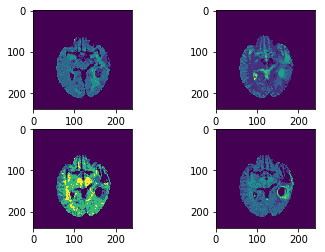

In [56]:
from matplotlib import pyplot

with tf.Session() as sess:
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    sh_images = sess.run(sh_images)
    img = sh_images.astype(np.uint8)
    print(img.shape)
    for i in range(4):
        pyplot.subplot(2,2,i+1)
        pyplot.imshow(img[1,0,:,:,i])
    coord.request_stop()
    # Wait for threads to stop
    coord.join(threads)